In [1]:
print('hêlo')

hêlo


In [6]:
import requests
import json
import textwrap

In [3]:
OLLAMA_URL = "http://localhost:11434/api/generate"
payload = {
    "model": "mistral",
    "prompt": "Hãy giải thích AI là gì một cách đơn giản.",
    "stream": True
}

In [4]:
line_width = 10100  
current_line_length = 0

In [5]:
# Gửi request stream
response = requests.post(OLLAMA_URL, json=payload, stream=True)

# Xử lý từng chunk JSON
for line in response.iter_lines():
    if line:
        data = json.loads(line.decode('utf-8'))
        chunk = data.get("response", "")
        
        for char in chunk:
            print(char, end="", flush=True)
            current_line_length += 1
            if current_line_length >= line_width:
                print()  # xuống dòng
                current_line_length = 0


 AI (Artificial Intelligence) là một khái niệm chung đặt tên cho các công cụ và phương pháp sử dụng máy tính để tạo ra hệ thống có thể sinh lớp hoạt động, xử lý thông tin và giải quyết vấn đề mà tương tự với việc con người hoạt động. AI bao gồm nhiều loại công cụ phân tán

KeyboardInterrupt: 

In [7]:
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import json

In [9]:
llm = Ollama(base_url="http://localhost:11434", model="mistral")

In [ ]:
ALLOWED_RELATIONS = [
    "isPartOf - A là một phần/thành phần của B", 
    "relatedTo - A có liên quan tổng quát đến B", 
    "enables - A cho phép/tạo điều kiện cho B" 
]

In [131]:
paragraph = """Hợp kim titanium (Ti-6Al-4V) được sử dụng rộng rãi trong công nghiệp hàng không vũ trụ nhờ tỉ lệ độ bền trên khối lượng cao và khả năng chống ăn mòn vượt trội. Cấu trúc vi mô của Ti-6Al-4V bao gồm pha alpha (hcp) và pha beta (bcc), được hình thành thông qua quá trình xử lý nhiệt và rèn dập. """


In [ ]:
#cần prompt thật kĩ, ví dụ output đầy đủ

In [142]:
relations_text = "\n".join(
    [f'{i+1}. {relation}'
     for i, relation in enumerate(ALLOWED_RELATIONS)]
)

template_node = """Extract entities from the following paragraph to build a knowledge graph.

Paragraph:
{paragraph}

Return the exact JSON result in the following format (do not add anything else):

{{
  "entities": [
    {{"name": "<Entity Name>"}}
  ]
}}

All nouns appearing in the paragraph will become an entity.
If an entity has a proper name, use the proper name as the entity name.
For example:
"The programming language is very popular in Vietnam" --> entities: programming language, Vietnam.
"The programming language (Java) is very popular in Vietnam" --> entities: Java, Vietnam.

Return JSON only, no additional explanations."""


template_edge = """Create relationships for the list of entities, using context from the paragraph to build a knowledge graph.

Entity list:
{list_nodes}

Paragraph:
{paragraph}

⚠️ Only create edges between entities that are present in the entity list. Do not create edges to or from entities outside this list.

Return the exact JSON result in the following format (do not add anything else):

{{
  "edges": [
    {{"source": "<Name of entity>", "target": "<Name of entity>"}}
  ]
}}

Return JSON only, no additional explanations."""




In [116]:
print(paragraph)

Hợp kim titanium (Ti-6Al-4V) được sử dụng rộng rãi trong công nghiệp hàng không vũ trụ nhờ tỉ lệ độ bền trên khối lượng cao và khả năng chống ăn mòn vượt trội. Cấu trúc vi mô của Ti-6Al-4V bao gồm pha alpha (hcp) và pha beta (bcc), được hình thành thông qua quá trình xử lý nhiệt và rèn dập. 


In [135]:
prompt_gen_node = PromptTemplate(
    input_variables=["paragraph"],
    template=template_node
)

chain_gen_node = LLMChain(llm=llm, prompt=prompt_gen_node)

nodes_text = chain_gen_node.invoke({
    "paragraph": paragraph
})

In [136]:
nodes_json = json.loads(nodes_text["text"])
print(json.dumps(nodes_json, indent=2, ensure_ascii=False))

{
  "entities": [
    {
      "name": "Hợp kim titanium"
    },
    {
      "name": "Ti-6Al-4V"
    },
    {
      "name": "công nghiệp hàng không vũ trụ"
    },
    {
      "name": "khối lượng"
    },
    {
      "name": "độ bền"
    },
    {
      "name": "khả năng chống ăn mòn"
    },
    {
      "name": "pha alpha"
    },
    {
      "name": "pha beta"
    }
  ]
}


In [143]:
prompt_gen_edge = PromptTemplate(
    input_variables=["list_nodes", "paragraph"],
    template=template_edge
)

chain_gen_edge = LLMChain(llm=llm, prompt=prompt_gen_edge)

edges_text = chain_gen_edge.invoke({
    "list_nodes": nodes_text,
    "paragraph": paragraph
})

In [144]:
edges_json = json.loads(edges_text["text"])
print(json.dumps(edges_json, indent=2, ensure_ascii=False))

{
  "edges": [
    {
      "source": "Hợp kim titanium",
      "target": "Ti-6Al-4V"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "công nghiệp hàng không vũ trụ"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "khối lượng"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "độ bền"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "khả năng chống ăn mòn"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "pha alpha"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "pha beta"
    }
  ]
}


In [149]:
#loại bỏ edge không tồn tại
node_ids = {node["name"] for node in nodes_json["entities"]}

#chỉ lấy edge kết nối các node có tồn tại
filtered_edges = [
    edge for edge in edges_json["edges"]
    if edge["source"] in node_ids and edge["target"] in node_ids
]

edges_json["edges"] = filtered_edges

kg = {
    "nodes": nodes_json["entities"],
    "edges": edges_json["edges"]
}
print(json.dumps(kg, indent=2, ensure_ascii=False))


{
  "nodes": [
    {
      "name": "Hợp kim titanium"
    },
    {
      "name": "Ti-6Al-4V"
    },
    {
      "name": "công nghiệp hàng không vũ trụ"
    },
    {
      "name": "khối lượng"
    },
    {
      "name": "độ bền"
    },
    {
      "name": "khả năng chống ăn mòn"
    },
    {
      "name": "pha alpha"
    },
    {
      "name": "pha beta"
    }
  ],
  "edges": [
    {
      "source": "Hợp kim titanium",
      "target": "Ti-6Al-4V"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "công nghiệp hàng không vũ trụ"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "khối lượng"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "độ bền"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "khả năng chống ăn mòn"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "pha alpha"
    },
    {
      "source": "Ti-6Al-4V",
      "target": "pha beta"
    }
  ]
}


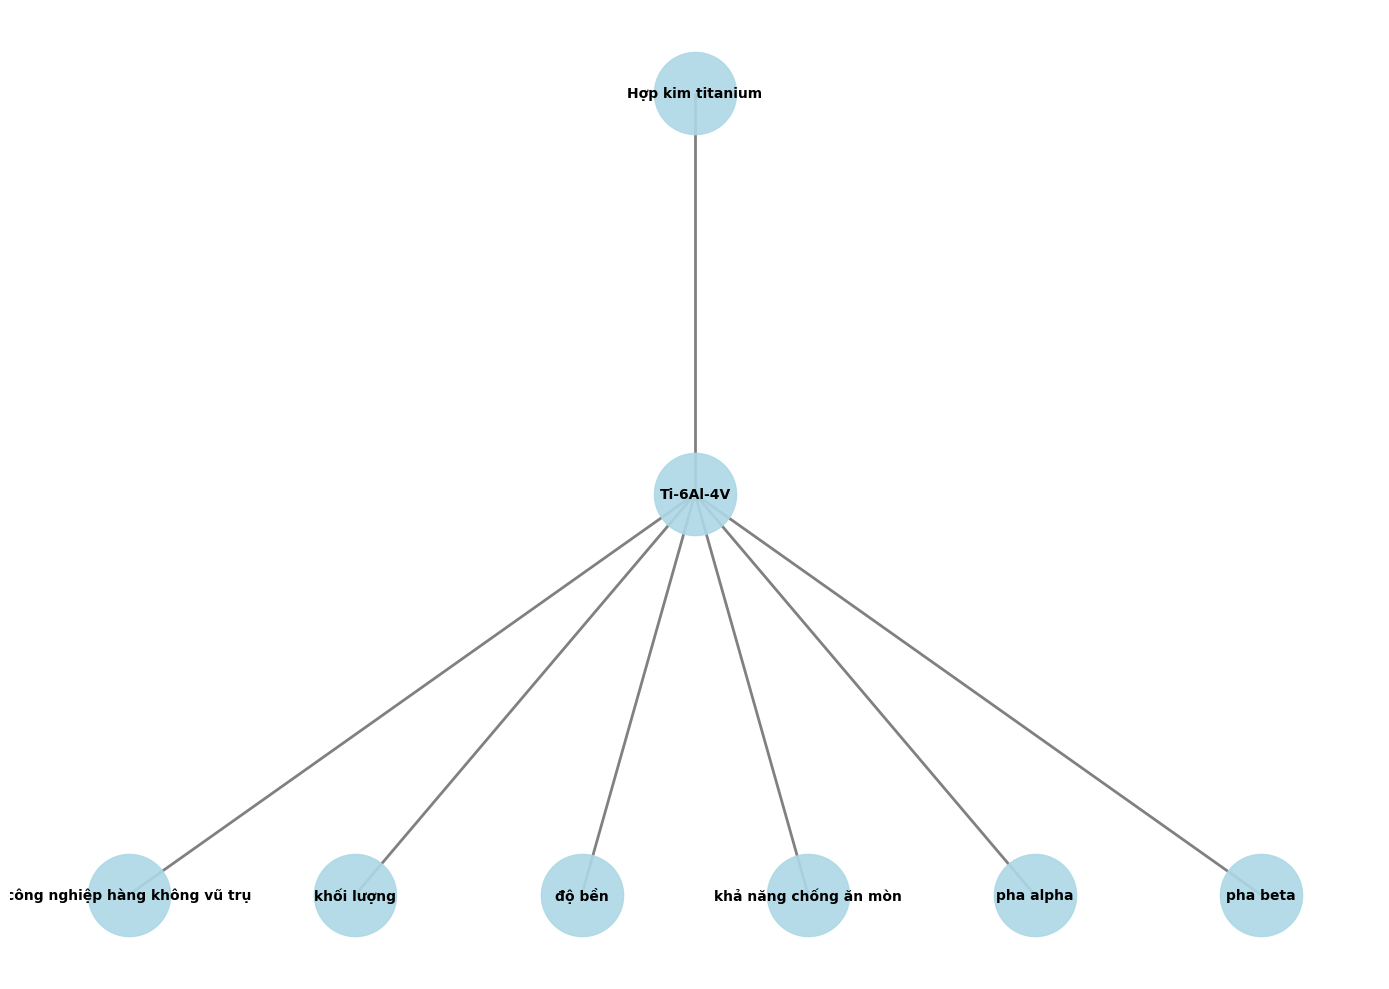

In [156]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for node in kg["nodes"]:
    G.add_node(node["name"])

for edge in kg["edges"]:
    G.add_edge(edge["source"], edge["target"])

plt.figure(figsize=(14, 10))

# Tạo layout phân tầng tự động theo độ sâu
def assign_levels(G):
    levels = {}
    # Tìm root nodes (không có incoming edges)
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    if not roots:
        roots = list(G.nodes())[:1]  # Nếu có cycle, chọn 1 node làm root
    
    # BFS để gán level
    from collections import deque
    queue = deque([(root, 0) for root in roots])
    visited = set()
    
    while queue:
        node, level = queue.popleft()
        if node in visited:
            continue
        visited.add(node)
        levels[node] = max(levels.get(node, 0), level)
        
        for successor in G.successors(node):
            if successor not in visited:
                queue.append((successor, level + 1))
    
    # Gán level cho các node chưa được visit
    for node in G.nodes():
        if node not in levels:
            levels[node] = 0
    
    return levels

levels = assign_levels(G)

# Tạo position dựa trên level
pos = {}
level_nodes = {}
for node, level in levels.items():
    if level not in level_nodes:
        level_nodes[level] = []
    level_nodes[level].append(node)

max_level = max(levels.values())
for level, nodes in level_nodes.items():
    for i, node in enumerate(nodes):
        x = (i - len(nodes)/2) * 2
        y = max_level - level  # Đảo ngược để level 0 ở trên
        pos[node] = (x, y)

nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=3500, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=False, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="red")

plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
with open("knowledge_graph.json", "w", encoding="utf-8") as f:
    json.dump(kg, f, ensure_ascii=False, indent=2)